# Modelos de Deep Learning

Laboratorio 03 – Deep Learning

Edwin Ortega 22305 - Esteban Zambrano 22119 - Diego García 22404

Link del repositorio:<br>
https://github.com/EstebanZG999/Lab3_DS

### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
#TensorFlow no está instalado en este entorno.

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

### Verifica entorno

In [3]:
# Verifica CUDA disponible
print("¿CUDA disponible?:", torch.cuda.is_available())

# Verifica GPU
if torch.cuda.is_available():
    print("GPU detectada:", torch.cuda.get_device_name(0))

¿CUDA disponible?: True
GPU detectada: NVIDIA GeForce RTX 4060 Laptop GPU


### Preprocesamiento y Dataset

In [4]:
class PolyMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Dataset personalizado para PolyMNIST.
        - root_dir: carpeta raíz que contiene subcarpetas m0, m1, ..., m4.
        - transform: transformaciones a aplicar a cada imagen.
        """
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for label in range(5):  # m0 = 0, m1 = 1, ..., m4 = 4
            class_dir = os.path.join(root_dir, f"m{label}")
            for img_name in os.listdir(class_dir):
                if img_name.endswith(".png"):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("L")  # convertir a escala de grises
        if self.transform:
            image = self.transform(image)

        return image, label


Cargar el dataset y crear el DataLoader

In [6]:
# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((28, 28)),       
    transforms.ToTensor(),             
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset y DataLoader
train_dir = "../data/PolyMNIST/MMNIST/train" 
test_dir = "../data/PolyMNIST/MMNIST/test"   

train_dataset = PolyMNISTDataset(root_dir=train_dir, transform=transform)
test_dataset = PolyMNISTDataset(root_dir=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verifica que funciona
images, labels = next(iter(train_loader))
print(f"Shape batch imágenes: {images.shape}")
print(f"Labels: {labels[:10]}")


Shape batch imágenes: torch.Size([64, 1, 28, 28])
Labels: tensor([2, 0, 3, 4, 1, 0, 4, 3, 2, 1])


GPU Check en el loader

In [7]:
# GPU Check en el loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)

# Mover un batch de prueba a GPU
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
print("Datos en GPU:", images.device)

Entrenando en: cuda
Datos en GPU: cuda:0


### Primer Modelo CNN 

In [26]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reducción de tamaño a la mitad
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Flatten final
        self.fc2 = nn.Linear(128, 5)  # 5 clases: m0 a m4

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [1, 28, 28] -> [16, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [16, 14, 14] -> [32, 7, 7]
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

##### Entrenaiento primer modelo

In [27]:
# Función de pérdida y optimizador
model = CNNModel().to(device)
print("Modelo en:", next(model.parameters()).device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Verifica que estemos entrenando en GPU
assert device.type == "cuda", "La GPU no se está utilizando. Revisa tu configuración."

train_losses = []
train_accuracies = []

# Bucle de entrenamiento
epochs = 5
for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Época {epoch}/{epochs} — Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Evaluación en el set de test
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_loss /= total
test_acc  = correct / total
print(f"\n— Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Modelo en: cuda:0
Época 1/5 — Loss: 0.2996, Accuracy: 0.8850
Época 2/5 — Loss: 0.0941, Accuracy: 0.9668
Época 3/5 — Loss: 0.0583, Accuracy: 0.9792
Época 4/5 — Loss: 0.0435, Accuracy: 0.9846
Época 5/5 — Loss: 0.0358, Accuracy: 0.9872

— Test Loss: 0.0321, Test Accuracy: 0.9888


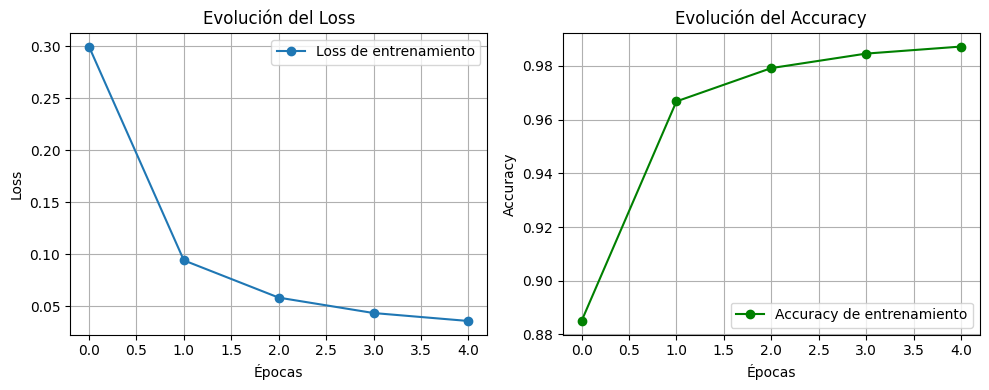

In [28]:
plt.figure(figsize=(10, 4))

# Gráfica del Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', label="Loss de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Evolución del Loss")
plt.grid(True)
plt.legend()

# Gráfica del Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green', label="Accuracy de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Evolución del Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Segundo Modelo CNN 

In [39]:
class CNNModelV2(nn.Module):
    def __init__(self):
        super(CNNModelV2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))        
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.dropout1(x)

        x = self.pool(F.relu(self.conv3(x))) 
        x = self.dropout2(x)

        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x


##### Entrenaiento segundo modelo

In [40]:
model_v2 = CNNModelV2().to(device)
print("Modelo en:", next(model_v2.parameters()).device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v2.parameters(), lr=0.001)

train_losses_v2 = []
train_accuracies_v2 = []

epochs = 5
for epoch in range(1, epochs+1):
    model_v2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_v2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    train_losses_v2.append(epoch_loss)
    train_accuracies_v2.append(epoch_acc)
    print(f"Época {epoch}/{epochs} — Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Modelo en: cuda:0
Época 1/5 — Loss: 0.2109, Accuracy: 0.9221
Época 2/5 — Loss: 0.0474, Accuracy: 0.9851
Época 3/5 — Loss: 0.0317, Accuracy: 0.9897
Época 4/5 — Loss: 0.0255, Accuracy: 0.9917
Época 5/5 — Loss: 0.0215, Accuracy: 0.9932


In [51]:
model_v2.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_v2(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

# Promediar loss
test_loss /= total
test_acc = correct / total

print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")



Test Loss: 0.0090, Test Accuracy: 0.9970


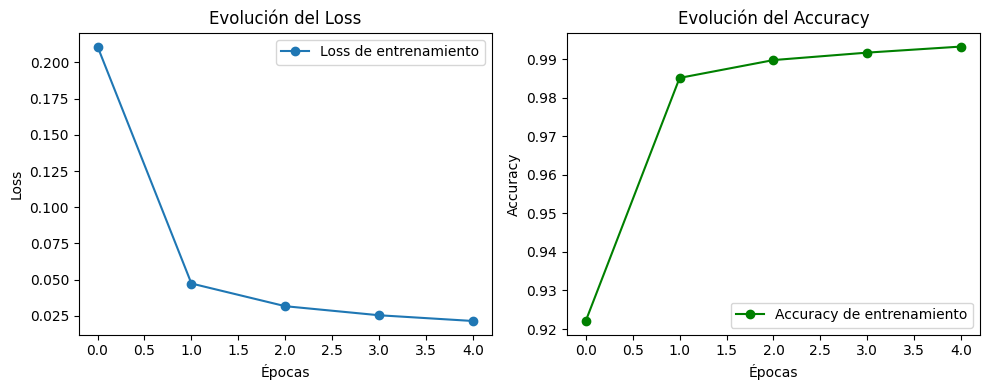

In [52]:
epochs_range = range(epochs)
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses_v2, marker='o', label='Loss de entrenamiento')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Evolución del Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies_v2, marker='o', label='Accuracy de entrenamiento', color='green')
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Evolución del Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### Modelo de Redes Neuronales

In [ ]:
# Image Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_augmenter = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

class PolyMNISTGenerator(Sequence):
    def __init__(self, file_list, batch_size=64, img_size=(28, 28), shuffle=True, augmenter=None):
        self.file_list = file_list  # lista de (ruta_completa, nombre_archivo)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmenter = augmenter
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_list[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((len(batch_files), *self.img_size, 1), dtype='float32')
        y = np.zeros((len(batch_files), 10), dtype='float32')

        for i, (full_path, fname) in enumerate(batch_files):
            img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img.astype('uint8')

            # Expandir a 3 canales (para ImageDataGenerator)
            img_rgb = np.repeat(img[..., np.newaxis], 3, axis=-1)

            # Aplicar augmentación
            if self.augmenter:
                img_aug = self.augmenter.random_transform(img_rgb)
                img = cv2.cvtColor(img_aug, cv2.COLOR_RGB2GRAY)

            # Normalizar y dejar en forma (28, 28, 1)
            img = img.astype('float32') / 255.0
            img = img.reshape(*self.img_size, 1)

            X[i] = img

            label = int(os.path.splitext(fname)[0].split('.')[1])
            y[i] = to_categorical(label, num_classes=10)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_list)

In [22]:
# Sin implementar augmentación
class PolyMNISTGenerator(Sequence):
    def __init__(self, file_list, batch_size=64, img_size=(28, 28), shuffle=True):
        self.file_list = file_list  # lista de (ruta_completa, nombre_archivo)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_list[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((len(batch_files), *self.img_size, 1), dtype='float32')
        y = np.zeros((len(batch_files), 10), dtype='float32')

        for i, (full_path, fname) in enumerate(batch_files):
            img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img.astype('float32') / 255.0
            X[i] = img.reshape(*self.img_size, 1)

            label = int(os.path.splitext(fname)[0].split('.')[1])
            y[i] = to_categorical(label, num_classes=10)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_list)


In [23]:
def collect_files(base_dir, modalities=["m0", "m1", "m2", "m3", "m4"]):
    file_list = []
    for mod in modalities:
        mod_path = os.path.join(base_dir, mod)
        for fname in os.listdir(mod_path):
            if fname.endswith('.png'):
                full_path = os.path.join(mod_path, fname)
                file_list.append((full_path, fname))
    return file_list

# Ruta base
BASE_DIR = "../data/PolyMNIST/MMNIST/train"

# Recolectar todos los archivos
all_files = collect_files(BASE_DIR)

# Dividir en train/val
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Crear generadores
train_gen = PolyMNISTGenerator(train_files, batch_size=64)
# train_gen = PolyMNISTGenerator(train_files, batch_size=64, augmenter=data_augmenter)
val_gen = PolyMNISTGenerator(val_files, batch_size=64, shuffle=False)


In [24]:
RNModel = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])


In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [26]:
RNModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = RNModel.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stop]
)


c:\Users\dgv31\OneDrive\Documents\Universidad\Semestre 8\data science\Lab2_DS\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 218s 58ms/step - accuracy: 0.4492 - loss: 1.6147 - val_accuracy: 0.6729 - val_loss: 1.0242
Epoch 2/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 234s 62ms/step - accuracy: 0.7016 - loss: 0.9511 - val_accuracy: 0.7398 - val_loss: 0.8436
Epoch 3/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 214s 57ms/step - accuracy: 0.7499 - loss: 0.8056 - val_accuracy: 0.7508 - val_loss: 0.7944
Epoch 4/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 183s 49ms/step - accuracy: 0.7707 - loss: 0.7396 - val_accuracy: 0.7699 - val_loss: 0.7446
Epoch 5/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 246s 66ms/step - accuracy: 0.7835 - loss: 0.7005 - val_accuracy: 0.7909 - val_loss: 0.6891
Epoch 6/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 192s 51ms/step - accuracy: 0.7940 - loss: 0.6634 - val_accuracy: 0.7911 - val_loss: 0.6935
Epoch 7/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 221s 59ms/step - accuracy: 0.8010 - loss: 0.6418 - val_accuracy: 0.8042 - val_loss: 0.6541
Epoch 8/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 176s 47ms/step - accuracy: 

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8068 - loss: 0.6493
Precisión en validación: 80.42%


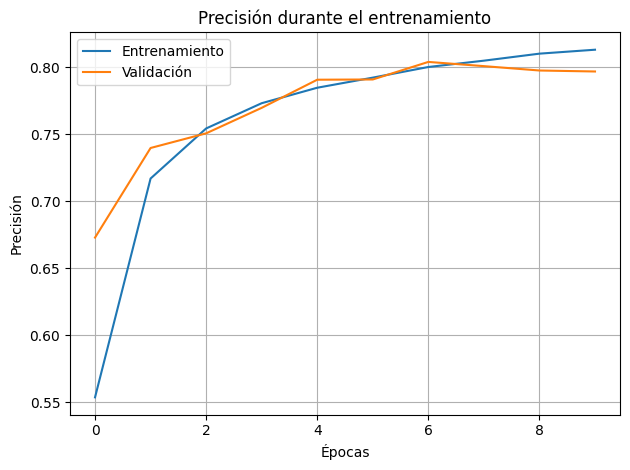

In [28]:
val_loss, val_acc = RNModel.evaluate(val_gen)
print(f"Precisión en validación: {val_acc*100:.2f}%")

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Ruta de la imagen
img_path = "ruta/a/tu/imagen.png"

# Cargar imagen en escala de grises
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Redimensionar a 28x28
img = cv2.resize(img, (28, 28))

# Mostrar la imagen
plt.imshow(img, cmap='gray')
plt.title("Imagen personalizada")
plt.axis('off')
plt.show()

# Normalizar y dar forma
img = img.astype('float32') / 255.0
img = img.reshape(1, 28, 28, 1)

# Predecir con el modelo entrenado
pred = RNModel.predict(img)
clase = np.argmax(pred)

print(f"Predicción: {clase} (confianza: {np.max(pred)*100:.2f}%)")


### Modelo MLP 

In [1]:
# ----------------------------------------------------------------------
# 1. Imports
# ----------------------------------------------------------------------

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2, time
from concurrent.futures import ThreadPoolExecutor
import torch, torch.nn as nn, torch.optim as optim
import torch_directml
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import albumentations as A

In [2]:
# ----------------------------------------------------------------------
# 2. Parámetros y rutas
# ----------------------------------------------------------------------
BASE_PATH   = "../data/PolyMNIST/MMNIST/train"
MODALITIES  = ["m0", "m1", "m2", "m3", "m4"]   # usa ["m0"] para pruebas
IMG_SIZE    = (28, 28)
PCA_VAR     = 0.95
TEST_RATIO  = 0.20
BATCH_SZ    = 2048
EPOCHS      = 30
LR          = 2e-3
N_THREADS   = 16

In [3]:
# ----------------------------------------------------------------------
# 3. Carga, filtrado, escalado y PCA
# ----------------------------------------------------------------------
def load_polymnist_modality_labels(base_path, modalities, img_size, n_threads=N_THREADS):
    paths = []
    labels = []
    for mi, mod in enumerate(modalities):
        folder = os.path.join(base_path, mod)
        for f in os.listdir(folder):
            if f.endswith(".png"):
                paths.append(os.path.join(folder, f))
                labels.append(mi)  # m0→0, m1→1, ..., m4→4

    def _read(p_label):
        p, lbl = p_label
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img.shape != img_size:
            img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)
        return img.flatten(), lbl

    with ThreadPoolExecutor(max_workers=n_threads) as pool:
        X_list, y_list = zip(*pool.map(_read, zip(paths, labels)))
    X = np.stack(X_list, dtype=np.float32) / 255.0
    y = np.array(y_list)
    return X, y

print("➜ Cargando PolyMNIST …")
t0 = time.time()
X, y = load_polymnist_modality_labels(BASE_PATH, MODALITIES, IMG_SIZE)
print(f"   · {X.shape[0]} imágenes cargadas en {time.time()-t0:.1f}s")
print("Etiquetas únicas:", np.unique(y))
N_CLASSES = len(np.unique(y))  # debería ser 5


➜ Cargando PolyMNIST …
   · 300000 imágenes cargadas en 18.7s
Etiquetas únicas: [0 1 2 3 4]


In [ ]:
# ----------------------------------------------------------------------
# 4. Augmentación 
# ----------------------------------------------------------------------
augmenter = A.Compose([
    A.Rotate(limit=15, border_mode=0, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, border_mode=0, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
])

def augment_dataset(X_orig, y_orig, n_copies=1, img_size=IMG_SIZE):
    X_list, y_list = [], []
    for _ in range(n_copies):
        for xi, yi in zip(X_orig, y_orig):
            img = (xi.reshape(img_size) * 255).astype("uint8")
            aug = augmenter(image=img)["image"]
            aug = aug.astype("float32") / 255.0
            X_list.append(aug.flatten())
            y_list.append(yi)
    X_aug = np.stack(X_list, dtype=np.float32)
    y_aug = np.array(y_list)
    return X_aug, y_aug

# Generar augmentaciones y mezclar
X_aug, y_aug = augment_dataset(X, y, n_copies=1, img_size=IMG_SIZE)
X_combined = np.vstack([X, X_aug])
y_combined = np.hstack([y, y_aug])
print("Tamaño combinado (orig + augment):", X_combined.shape, y_combined.shape)

c:\Universidad Desktop\2025\Segundo\DataScience\Lab3_DS\dml_env\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\esteb\AppData\Local\Temp\ipykernel_980\1482933142.py:8: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),


Tamaño combinado (orig + augment): (600000, 784) (600000,)


In [ ]:
# ----------------------------------------------------------------------
# Escalado y PCA sobre el dataset aumentado
# ----------------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

pca = PCA(n_components=PCA_VAR, svd_solver="full", whiten=True, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"   · Dimensión reducida a {X_pca.shape[1]} comps (con augmentación)")

   · Dimensión reducida a 487 comps (con augmentación)


In [7]:
# ----------------------------------------------------------------------
# 5. Split Train / Test
# ----------------------------------------------------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X_pca, y_combined, test_size=TEST_RATIO, stratify=y_combined, random_state=42)
print(f"   · Train {X_tr.shape[0]}   Test {X_te.shape[0]}")

X_tr = X_tr.astype(np.float32)
X_te = X_te.astype(np.float32)

   · Train 480000   Test 120000


In [8]:
# ----------------------------------------------------------------------
# 6. Tensores y DataLoader  (DirectML device)
# ----------------------------------------------------------------------
device = torch_directml.device()
Xtr_t  = torch.from_numpy(X_tr).to(device)
ytr_t  = torch.from_numpy(y_tr).long().to(device)
Xte_t  = torch.from_numpy(X_te).to(device)
yte_t  = torch.from_numpy(y_te).long().to(device)

train_ds = torch.utils.data.TensorDataset(Xtr_t, ytr_t)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SZ, shuffle=True)

In [9]:
# ---------------------------------------------------------------
# 7. Modelo MLP
# -------------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(in_dim=X_pca.shape[1], n_classes=N_CLASSES).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [10]:
# --------------------------------------------------------------
# 8. Entrenamiento
# -------------------------------------------------------------------
import warnings
train_loss, val_acc = [], []

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        message=r"The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend*",
        category=UserWarning
    )

    print("Entrenando MLP (DirectML) …")
    
    crit = nn.CrossEntropyLoss()
    best_acc = 0
    patience = 5
    stale = 0

    for ep in range(1, EPOCHS + 1):
        # ---- entrenamiento ----
        running = 0.0
        for xb, yb in train_dl:
            opt.zero_grad()
            loss = crit(model(xb), yb) 
            loss.backward()
            opt.step()
            running += loss.item()
        epoch_loss = running / len(train_dl)
        train_loss.append(epoch_loss)

        # ---- validación rápida ----
        with torch.no_grad():
            preds = model(Xte_t).argmax(1)
            acc = (preds == yte_t).float().mean().item()
        val_acc.append(acc)
        print(f"Epoch {ep:02}/{EPOCHS}  loss {train_loss[-1]:.4f}  acc {acc*100:.2f}%")

                
        if acc > best_acc + 1e-4:
            best_acc = acc
            stale = 0
            best_state = model.state_dict()
        else:
            stale += 1
            if stale >= patience:
                print("Early stopping por estancamiento.")
                model.load_state_dict(best_state)
                break

Entrenando MLP (DirectML) …
Epoch 01/30  loss 1.3113  acc 60.48%
Epoch 02/30  loss 0.9156  acc 65.85%
Epoch 03/30  loss 0.8134  acc 67.51%
Epoch 04/30  loss 0.7754  acc 68.41%
Epoch 05/30  loss 0.7554  acc 68.91%
Epoch 06/30  loss 0.7408  acc 69.24%
Epoch 07/30  loss 0.7317  acc 69.53%
Epoch 08/30  loss 0.7229  acc 69.77%
Epoch 09/30  loss 0.7162  acc 69.95%
Epoch 10/30  loss 0.7107  acc 70.05%
Epoch 11/30  loss 0.7046  acc 69.97%
Epoch 12/30  loss 0.7022  acc 70.24%
Epoch 13/30  loss 0.6981  acc 70.29%
Epoch 14/30  loss 0.6949  acc 70.48%
Epoch 15/30  loss 0.6926  acc 70.52%
Epoch 16/30  loss 0.6896  acc 70.54%
Epoch 17/30  loss 0.6882  acc 70.52%
Epoch 18/30  loss 0.6861  acc 70.67%
Epoch 19/30  loss 0.6832  acc 70.65%
Epoch 20/30  loss 0.6820  acc 70.89%
Epoch 21/30  loss 0.6799  acc 70.85%
Epoch 22/30  loss 0.6783  acc 70.90%
Epoch 23/30  loss 0.6778  acc 70.75%
Epoch 24/30  loss 0.6740  acc 70.83%
Epoch 25/30  loss 0.6726  acc 70.93%
Epoch 26/30  loss 0.6732  acc 70.97%
Epoch 27/3

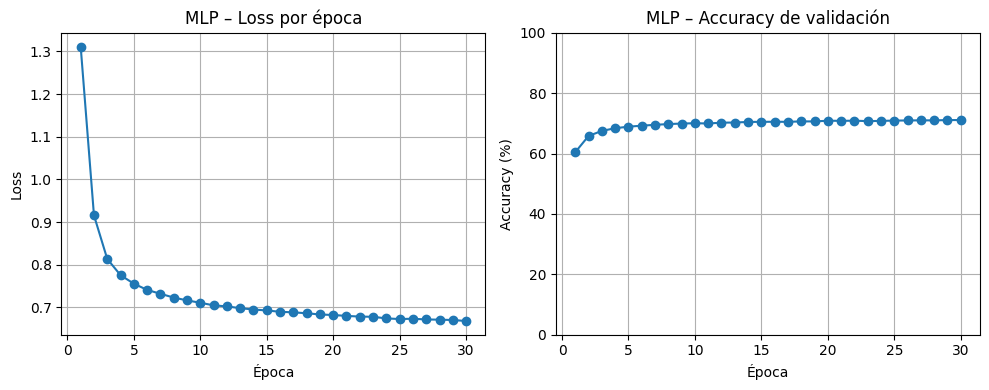


✔ Accuracy test final: 71.11 %


In [11]:
# ---------------------------------------------------------------
# 9. Evaluación
# -------------------------------------------------------------------
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 4))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o')
plt.title('MLP – Loss por época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)

# --- Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, [a*100 for a in val_acc], marker='o')
plt.title('MLP – Accuracy de validación')
plt.xlabel('Época')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n✔ Accuracy test final: {val_acc[-1]*100:.2f} %")

Carga del Dataset y cargar e Dataloader

In [15]:
# Transformación con augmentación para entrenamiento
transform_augmented = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Transformación sin augmentación (para test)
transform_original = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset y DataLoader
train_dir = "../data/PolyMNIST/MMNIST/train" 
test_dir = "../data/PolyMNIST/MMNIST/test"   

train_dataset = PolyMNISTDataset(root_dir=train_dir, transform=transform_augmented)  # <-- aquí sí usas augmentation
test_dataset = PolyMNISTDataset(root_dir=test_dir, transform=transform_original)     # <-- aquí NO usas augmentation

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verifica que funciona
images, labels = next(iter(train_loader))
print(f"Shape batch imágenes: {images.shape}")
print(f"Labels: {labels[:10]}")


Shape batch imágenes: torch.Size([64, 1, 28, 28])
Labels: tensor([2, 3, 1, 1, 4, 2, 4, 1, 4, 1])


##### Modelos con Augmentation

Entrenamiento modelo 1 con Augmentation

In [9]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reducción de tamaño a la mitad
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Flatten final
        self.fc2 = nn.Linear(128, 5)  # 5 clases: m0 a m4

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [1, 28, 28] -> [16, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [16, 14, 14] -> [32, 7, 7]
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [10]:
# Función de pérdida y optimizador
model = CNNModel().to(device)
print("Modelo en:", next(model.parameters()).device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Verifica que estemos entrenando en GPU
assert device.type == "cuda", "La GPU no se está utilizando. Revisa tu configuración."

train_losses = []
train_accuracies = []

# Bucle de entrenamiento
epochs = 5
for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Época {epoch}/{epochs} — Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Evaluación en el set de test
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_loss /= total
test_acc  = correct / total
print(f"\n— Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Modelo en: cuda:0
Época 1/5 — Loss: 0.4160, Accuracy: 0.8341
Época 2/5 — Loss: 0.1777, Accuracy: 0.9337
Época 3/5 — Loss: 0.1382, Accuracy: 0.9493
Época 4/5 — Loss: 0.1174, Accuracy: 0.9570
Época 5/5 — Loss: 0.1014, Accuracy: 0.9628

— Test Loss: 0.0463, Test Accuracy: 0.9843


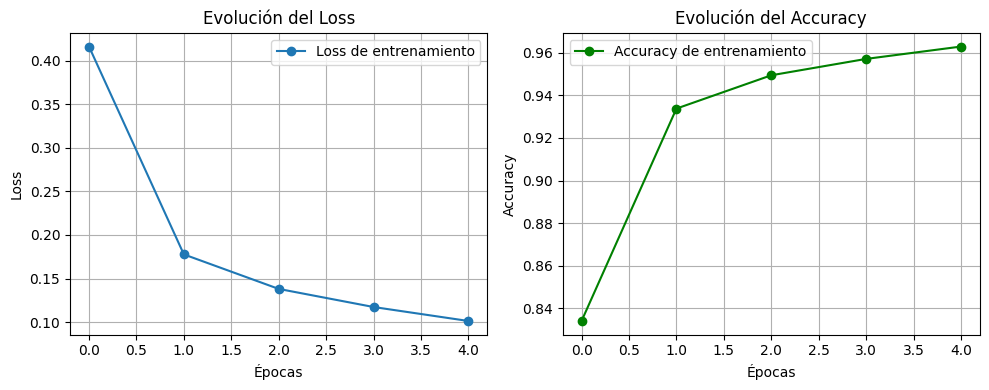

In [11]:
plt.figure(figsize=(10, 4))

# Gráfica del Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', label="Loss de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Evolución del Loss")
plt.grid(True)
plt.legend()

# Gráfica del Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green', label="Accuracy de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Evolución del Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Entrenamiento modelo 2 con Augmentation

In [16]:
class CNNModelV2(nn.Module):
    def __init__(self):
        super(CNNModelV2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))        
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.dropout1(x)

        x = self.pool(F.relu(self.conv3(x))) 
        x = self.dropout2(x)

        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [18]:
model_v2 = CNNModelV2().to(device)
print("Modelo en:", next(model_v2.parameters()).device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v2.parameters(), lr=0.001)

train_losses_v2 = []
train_accuracies_v2 = []

epochs = 5
for epoch in range(1, epochs + 1):
    model_v2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_v2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses_v2.append(epoch_loss)
    train_accuracies_v2.append(epoch_acc)
    print(f"Época {epoch}/{epochs} — Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Evaluación en test set
model_v2.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_v2(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_loss /= total
test_acc = correct / total
print(f"\n— Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Modelo en: cuda:0
Época 1/5 — Loss: 0.3720, Accuracy: 0.8560
Época 2/5 — Loss: 0.1248, Accuracy: 0.9575
Época 3/5 — Loss: 0.0898, Accuracy: 0.9695
Época 4/5 — Loss: 0.0753, Accuracy: 0.9746
Época 5/5 — Loss: 0.0668, Accuracy: 0.9773

— Test Loss: 0.0180, Test Accuracy: 0.9937


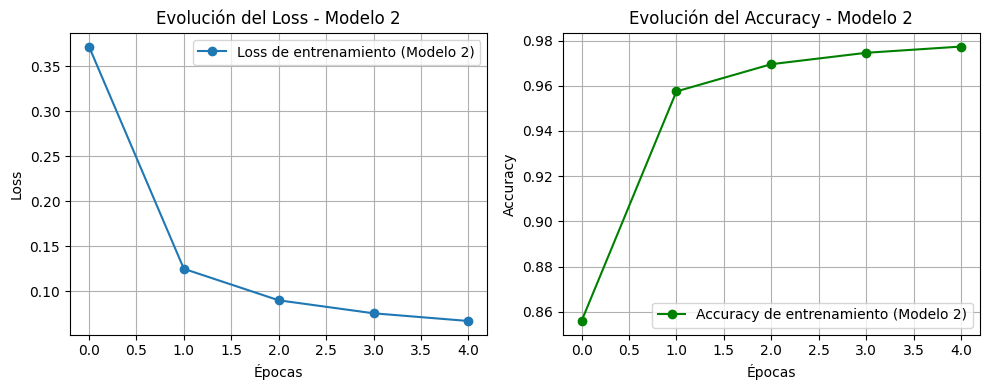

In [20]:
plt.figure(figsize=(10, 4))

# Gráfica del Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses_v2, marker='o', label="Loss de entrenamiento (Modelo 2)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Evolución del Loss - Modelo 2")
plt.grid(True)
plt.legend()

# Gráfica del Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_v2, marker='o', color='green', label="Accuracy de entrenamiento (Modelo 2)")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Evolución del Accuracy - Modelo 2")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()